In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from model_settings import ms
from df_collector import df_collector
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
root = Path().resolve().parent.parent
df_collector.root = root
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}")


##################
# training start #
##################

Fri Nov  8 11:13:59 2024


In [2]:
data = df_collector.cboe_spx_barriers().iloc[:,1:]
pricename = [f for f in data.columns if f.find('_price')!=-1 and f.find('spot_')==-1 and f.find('strike_')==-1][0]
filetag = f'cboe spx {pricename[:pricename.find('_',0)]}'
data = data[data[pricename]<data['spot_price']]
data = data[data[pricename]>data['spot_price']*0.01].reset_index(drop=True)
og_count = data.shape[0]
print(f'collected {pricename[:pricename.find('_',0)]} options')
data

collected barrier options


,spot_price,strike_price,barrier,days_to_maturity,updown,outin,w,barrier_type_name,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,calculation_date,date,barrier_price
0,5728.00000,5155.20000,2864.00000,60,Down,Out,call,DownOut,0.00000,0.01284,0.03891,0.04522,6.53448,-0.67033,2.06779,0.01856,2024-09-24 14:07:30.152,2024-09-24,622.60520
1,5728.00000,5155.20000,2864.00000,90,Down,Out,call,DownOut,0.00000,0.01284,0.03891,0.04522,6.53448,-0.67033,2.06779,0.01856,2024-09-24 14:07:30.152,2024-09-24,650.08160
2,5728.00000,5155.20000,2864.00000,180,Down,Out,call,DownOut,0.00000,0.01284,0.03891,0.04522,6.53448,-0.67033,2.06779,0.01856,2024-09-24 14:07:30.152,2024-09-24,727.65970
3,5728.00000,5155.20000,2864.00000,180,Down,Out,put,DownOut,0.00000,0.01284,0.03891,0.04522,6.53448,-0.67033,2.06779,0.01856,2024-09-24 14:07:30.152,2024-09-24,62.46879
4,5728.00000,5155.20000,2864.00000,360,Down,Out,call,DownOut,0.00000,0.01284,0.03891,0.04522,6.53448,-0.67033,2.06779,0.01856,2024-09-24 14:07:30.152,2024-09-24,863.31878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7583,5857.00000,6442.70000,8785.50000,360,Up,Out,put,UpOut,0.00000,0.01269,0.04181,0.00000,4.06705,-0.71781,1.48700,0.12159,2024-10-14 15:26:27.717,2024-10-14,459.13902
7584,5857.00000,6442.70000,8785.50000,540,Up,Out,call,UpOut,0.00000,0.01269,0.04181,0.00000,4.06705,-0.71781,1.48700,0.12159,2024-10-14 15:26:27.717,2024-10-14,84.54404
7585,5857.00000,6442.70000,8785.50000,540,Up,Out,put,UpOut,0.00000,0.01269,0.04181,0.00000,4.06705,-0.71781,1.48700,0.12159,2024-10-14 15:26:27.717,2024-10-14,373.33710
7586,5857.00000,6442.70000,8785.50000,720,Up,Out,call,UpOut,0.00000,0.01269,0.04181,0.00000,4.06705,-0.71781,1.48700,0.12159,2024-10-14 15:26:27.717,2024-10-14,107.86907


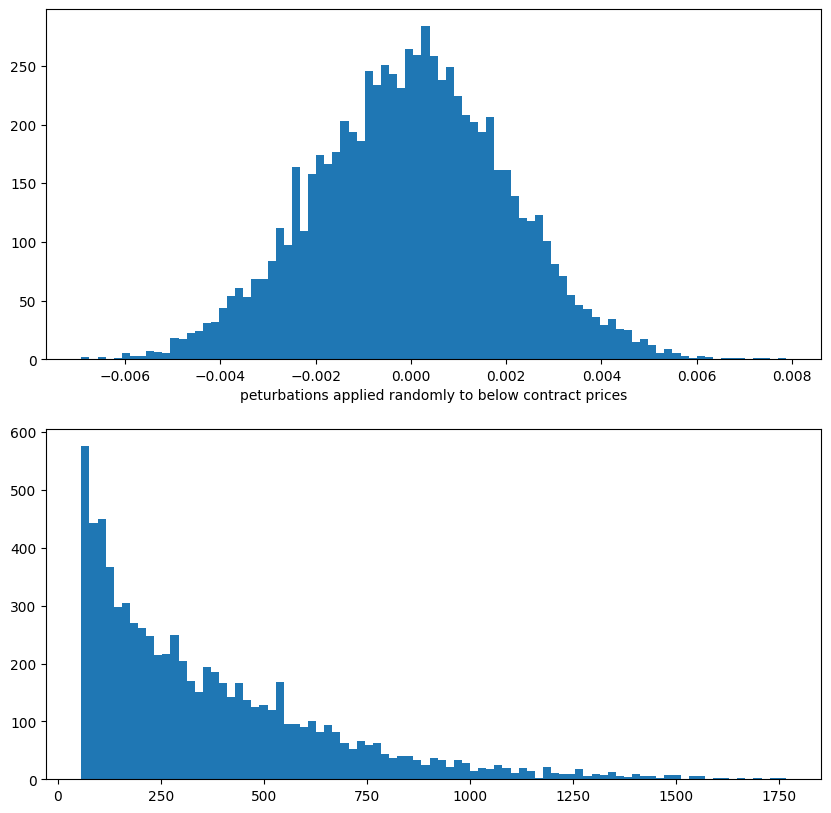

In [3]:
data = data[data[pricename]<data['spot_price']]
data = data[data[pricename]>data['spot_price']*0.01].reset_index(drop=True)

data['observed_price'] = data[pricename].apply(lambda x: max(x + np.random.normal(scale=0.002),0) if x > 0 else 0)
data = data[data['observed_price']>0]

p = data[pricename]-data['observed_price']
plotprices = data['observed_price']

fig,axs = plt.subplots(2,figsize=(10,10))
axs[0].hist(p,bins=int(len(p)**0.5))
axs[0].set_xlabel('peturbations applied randomly to below contract prices')
axs[1].hist(plotprices,bins=int(len(plotprices)**0.5))
plt.show()

# training procedure

In [4]:
from convsklearn import convsklearn
trainer = convsklearn()
help(trainer)
print('instance variables:')
trainer.__dict__

Help on convsklearn in module convsklearn.convsklearn object:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'])
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'])
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates, plot=True)
 |
 |  run_dnn(self, print_details=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object

instance variables:


{'raw_data': Empty DataFrame
 Columns: []
 Index: [],
 'dataset': Empty DataFrame
 Columns: []
 Index: [],
 'target_name': 'observed_price',
 'excluded_features': ['barrier_price',
  'asian',
  'observed_price',
  'outin',
  'updown',
  'n_fixings'],
 'numerical_features': [],
 'categorical_features': [],
 'feature_set': [],
 'n_features': 0,
 'development_dates': {},
 'test_dates': {},
 'train_data': {},
 'test_data': {},
 'train_X': {},
 'train_y': {},
 'test_X': {},
 'test_y': {},
 'preprocessor': None,
 'pipeline': None,
 'model': None,
 'model_fit': None,
 'dnn_runtime': 0,
 'numerical_scaler': StandardScaler()}

In [5]:
trainer.load_data(data)
trainer.__dict__
trainer.dataset

,spot_price,strike_price,barrier,days_to_maturity,updown,outin,w,barrier_type_name,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,calculation_date,date,barrier_price,observed_price
0,5728.00000,5155.20000,2864.00000,60,Down,Out,call,DownOut,0.00000,0.01284,0.03891,0.04522,6.53448,-0.67033,2.06779,0.01856,2024-09-24 14:07:30.152,2024-09-24,622.60520,622.60841
1,5728.00000,5155.20000,2864.00000,90,Down,Out,call,DownOut,0.00000,0.01284,0.03891,0.04522,6.53448,-0.67033,2.06779,0.01856,2024-09-24 14:07:30.152,2024-09-24,650.08160,650.07873
2,5728.00000,5155.20000,2864.00000,180,Down,Out,call,DownOut,0.00000,0.01284,0.03891,0.04522,6.53448,-0.67033,2.06779,0.01856,2024-09-24 14:07:30.152,2024-09-24,727.65970,727.66420
3,5728.00000,5155.20000,2864.00000,180,Down,Out,put,DownOut,0.00000,0.01284,0.03891,0.04522,6.53448,-0.67033,2.06779,0.01856,2024-09-24 14:07:30.152,2024-09-24,62.46879,62.46978
4,5728.00000,5155.20000,2864.00000,360,Down,Out,call,DownOut,0.00000,0.01284,0.03891,0.04522,6.53448,-0.67033,2.06779,0.01856,2024-09-24 14:07:30.152,2024-09-24,863.31878,863.32032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7583,5857.00000,6442.70000,8785.50000,360,Up,Out,put,UpOut,0.00000,0.01269,0.04181,0.00000,4.06705,-0.71781,1.48700,0.12159,2024-10-14 15:26:27.717,2024-10-14,459.13902,459.13880
7584,5857.00000,6442.70000,8785.50000,540,Up,Out,call,UpOut,0.00000,0.01269,0.04181,0.00000,4.06705,-0.71781,1.48700,0.12159,2024-10-14 15:26:27.717,2024-10-14,84.54404,84.54274
7585,5857.00000,6442.70000,8785.50000,540,Up,Out,put,UpOut,0.00000,0.01269,0.04181,0.00000,4.06705,-0.71781,1.48700,0.12159,2024-10-14 15:26:27.717,2024-10-14,373.33710,373.33787
7586,5857.00000,6442.70000,8785.50000,720,Up,Out,call,UpOut,0.00000,0.01269,0.04181,0.00000,4.06705,-0.71781,1.48700,0.12159,2024-10-14 15:26:27.717,2024-10-14,107.86907,107.87194


## preprocessing

In [6]:
dates = pd.Series(np.sort(data['date'].unique()))
dates

0    2024-09-24
1    2024-10-07
2    2024-10-08
3    2024-10-09
4    2024-10-14
dtype: object

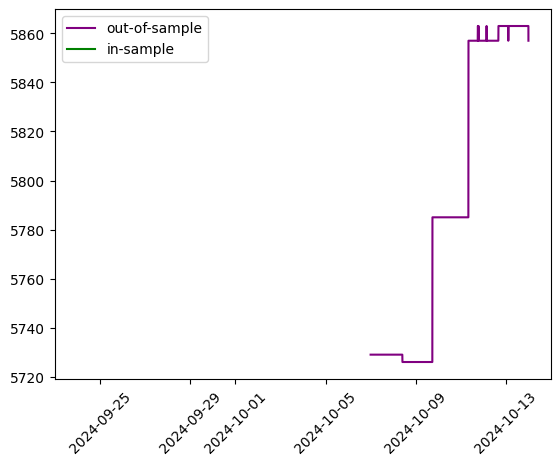

In [7]:
development_dates = dates[:len(dates)//4]
test_dates = dates[~dates.isin(development_dates)]
trainer.preprocess_data(development_dates,test_dates)

## training

In [8]:
trainer.run_dnn()


training on 1197 samples...

alpha: 0.01
hidden_layer_sizes: (14, 14)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 0.4054083824157715


In [9]:
print('instance varianbles:')
trainer.__dict__

instance varianbles:


{'raw_data':       spot_price  strike_price    barrier  days_to_maturity updown outin  \
 0     5728.00000    5155.20000 2864.00000                60   Down   Out   
 1     5728.00000    5155.20000 2864.00000                90   Down   Out   
 2     5728.00000    5155.20000 2864.00000               180   Down   Out   
 3     5728.00000    5155.20000 2864.00000               180   Down   Out   
 4     5728.00000    5155.20000 2864.00000               360   Down   Out   
 ...          ...           ...        ...               ...    ...   ...   
 7583  5857.00000    6442.70000 8785.50000               360     Up   Out   
 7584  5857.00000    6442.70000 8785.50000               540     Up   Out   
 7585  5857.00000    6442.70000 8785.50000               540     Up   Out   
 7586  5857.00000    6442.70000 8785.50000               720     Up   Out   
 7587  5857.00000    6442.70000 8785.50000               720     Up   Out   
 
          w barrier_type_name  rebate  dividend_rate  risk_fre

In [10]:
trainer.model_fit

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'barrier',
                                                                                        'days_to_maturity',
                                                                                        'rebate',
                                                                                        'dividend_rate',
                                                                                        'risk_free_rate',
                                                                                        'theta',
                                                                                        'kappa',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['w',
                                                                                        'barrier_type_name'])])),
                                                     ('regressor',
                                                      MLPRegressor(alpha=0.01,
                                                                   hidden_layer_sizes=(14,
                                                                                       14),
                                                                   learning_rate='adaptive',
                                                                   learning_rate_init=0.1,
                                                                   max_iter=500,
                                                                   solver='sgd',
                                                                   warm_start=True))]),
                           transformer=StandardScaler())

### initial test

In [11]:
train_test = trainer.test_prediction_accuracy()


in sample:
     RMSE: 19.755742054833583
     MAE: 14.588621506459292

out of sample:
     RMSE: 6645.317909973519
     MAE: 5030.684823929404


## saving

In [12]:
train_end = time.time()
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H%M%S%f"))
file_tag = str(train_end_tag + " " + filetag)
files_dir = os.path.join(models_dir,file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    joblib.dump(trainer.__dict__,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")

execute the command 'save_model()' to save the following model: 2024_11_08 111420568138 cboe spx barrier

cpu: 21.286510705947876
